In [1]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications import resnet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


In [2]:
def load_training():
    images = np.load(os.path.join('../Data_final_calcver', 'X_train.npy'))
    labels = np.load(os.path.join('../Data_final_calcver', 'train_calc_labels2_num.npy'))
    #FN = np.load(os.path.join('../Data_final_calcver', 'train_calc_FN.npy'))
    return images, labels#, FN


def load_testing():
    images = np.load(os.path.join('../Data_final_calcver', 'X_test.npy'))
    labels = np.load(os.path.join('../Data_final_calcver', 'test_calc_labels2_num.npy'))
    #FN = np.load(os.path.join('../Data_final_calcver', 'test_calc_FN.npy'))
    return images, labels#, FN

In [3]:
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 1535 	 Test size: 337
Image size: 256x256


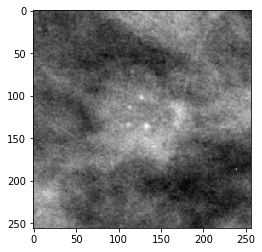

Label: 0


In [4]:
idx = 10

plt.imshow(test_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(test_labels[idx]))
#print("FN: " + str(test_FN[idx]))

In [5]:
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [6]:
train_images.shape

(1535, 256, 256, 1)

In [7]:
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [8]:
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [9]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [10]:
train_datagen.fit(train_images)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

preprocess_input(test_images);

In [11]:
def create_resnet50(verbose=False, fc_size=256, output = 2, dropout=None):
    
    from tensorflow.keras.applications import resnet50
    
    resnet50_base = resnet50.ResNet50(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    resnet50 = models.Sequential()
    resnet50.add(resnet50_base)

    resnet50.add(layers.Flatten())
    if dropout is not None:
        resnet50.add(layers.Dropout(dropout))
    resnet50.add(layers.Dense(fc_size, activation='relu'))
    resnet50.add(layers.Dense(output, activation='softmax'))

    # Freeze the convolutional base
    resnet50_base.trainable = False
    
    if verbose:
        resnet50_base.summary()
        resnet50.summary()

    return resnet50

In [12]:
resnet = resnet50.ResNet50(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
for layer in resnet.layers:
    layer.trainable = False
resnet_maxpool = resnet.get_layer('conv5_block3_out').output
FeatureFlatten = Flatten()(resnet_maxpool)
dense1 = Dense(1024, name = 'dense1', activation = 'relu')(FeatureFlatten)
dense2 = Dense(128, name = 'dense2', activation = 'relu')(dense1)
predictions = Dense(2, name = 'predictions', activation = 'softmax')(dense2)

new_resnet = Model(inputs = resnet.input, outputs = predictions)
new_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
resnet50_calc_benign_or_malignant_best_Adam = new_resnet

In [14]:
resnet50_calc_benign_or_malignant_best_RMSprop = new_resnet

### Adam

In [15]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet50_calc_benign_or_malignant_best_Adam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet50_calc_benign_or_malignant_best_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [16]:
# Train
history_resnet50_calc_benign_or_malignant_best_Adam = resnet50_calc_benign_or_malignant_best_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 6.3292 - recall: 0.5059
Epoch 00001: val_loss improved from inf to 1.07251, saving model to ../model/resnet50_calc_benign_or_malignant_best_Adam.h5
5/5 [==============================] - 17s 3s/step - loss: 5.2508 - recall: 0.5221 - val_loss: 1.0725 - val_recall: 0.6417
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2459 - recall: 0.6055
Epoch 00002: val_loss improved from 1.07251 to 0.60066, saving model to ../model/resnet50_calc_benign_or_malignant_best_Adam.h5
5/5 [==============================] - 14s 3s/step - loss: 1.1784 - recall: 0.6000 - val_loss: 0.6007 - val_recall: 0.6612
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7961 - recall: 0.6522
Epoch 00003: val_loss did not improve from 0.60066
5/5 [=======

Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5994 - recall: 0.7031
Epoch 00029: val_loss did not improve from 0.58345
5/5 [==============================] - 11s 2s/step - loss: 0.5904 - recall: 0.7031 - val_loss: 0.6792 - val_recall: 0.6645
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5338 - recall: 0.7324
Epoch 00030: val_loss did not improve from 0.58345
5/5 [==============================] - 11s 2s/step - loss: 0.5663 - recall: 0.7156 - val_loss: 0.6020 - val_recall: 0.6938
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6658 - recall: 0.6739
Epoch 00031: val_loss did not improve from 0.58345
5/5 [==============================] - 10s 2s/step - loss: 0.6305 - recall: 0.7007 - val_loss: 0.6339 - val_recall: 0.6710
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6430 - recall: 0.6957
Epoch 00032: val_loss did not improve from 0.58345
5/5 [==============================] - 10s 2s/step - loss: 

In [17]:
models.save_model(resnet50_calc_benign_or_malignant_best_Adam, '../model/resnet50_calc_benign_or_malignant_end_Adam.h5')

In [18]:
tra_loss_fe = history_resnet50_calc_benign_or_malignant_best_Adam.history['loss']
tra_acc_fe = history_resnet50_calc_benign_or_malignant_best_Adam.history['recall']
val_loss_fe = history_resnet50_calc_benign_or_malignant_best_Adam.history['val_loss']
val_acc_fe = history_resnet50_calc_benign_or_malignant_best_Adam.history['val_recall']

In [19]:
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet50_calc_benign_or_malignant = models.load_model('../model/resnet50_calc_benign_or_malignant_best_Adam.h5')
test_loss_fe, test_acc_fe = resnet50_calc_benign_or_malignant_best_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

In [20]:
print("resnet50 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 benign or malignant

Epoch [end]: 47
Epoch [opt]: 17
Valid recall [end]: 0.6710
Valid recall [opt]: 0.6450
Test recall [end]:  0.6736
Test recall [opt]:  0.6884
Valid loss [end]: 0.6637
Valid loss [opt]: 0.5835
Test loss [end]:  0.5761
Test loss [opt]:  0.5832


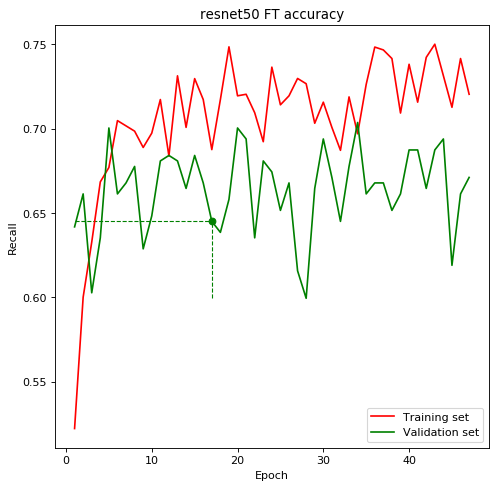

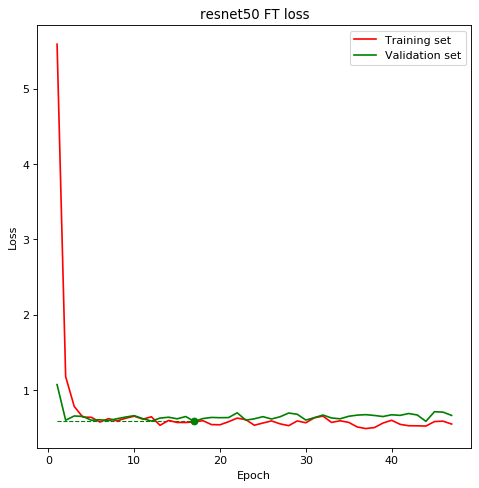

In [21]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### SGD

In [22]:
resnet50_calc_benign_or_malignant_best_SGD = create_resnet50(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet50_calc_benign_or_malignant_best_SGD.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet50_calc_benign_or_malignant_best_SGD.compile(optimizer=optimizers.SGD(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [23]:
# Train
history_resnet50_calc_benign_or_malignant_best_SGD = resnet50_calc_benign_or_malignant_best_SGD.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2278 - recall: 0.5664
Epoch 00001: val_loss improved from inf to 0.88953, saving model to ../model/resnet50_calc_benign_or_malignant_best_SGD.h5
5/5 [==============================] - 12s 2s/step - loss: 1.1957 - recall: 0.5734 - val_loss: 0.8895 - val_recall: 0.6352
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2123 - recall: 0.5977
Epoch 00002: val_loss did not improve from 0.88953
5/5 [==============================] - 10s 2s/step - loss: 1.2458 - recall: 0.5875 - val_loss: 0.9411 - val_recall: 0.6189
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2476 - recall: 0.5879
Epoch 00003: val_loss improved from 0.88953 to 0.80154, saving model to ../model/resnet50_calc_benign_or_malignant_best_SGD.h5
5/5 [==============================] - 11s 2s/step - loss: 1.1871 - recall: 0.6000 - val_l

Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8170 - recall: 0.6582
Epoch 00030: val_loss did not improve from 0.66374
5/5 [==============================] - 10s 2s/step - loss: 0.8542 - recall: 0.6484 - val_loss: 0.7036 - val_recall: 0.6515
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9322 - recall: 0.6152
Epoch 00031: val_loss did not improve from 0.66374
5/5 [==============================] - 10s 2s/step - loss: 0.9216 - recall: 0.6234 - val_loss: 0.7117 - val_recall: 0.6156
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9738 - recall: 0.5891
Epoch 00032: val_loss did not improve from 0.66374
5/5 [==============================] - 10s 2s/step - loss: 0.9465 - recall: 0.6037 - val_loss: 0.7248 - val_recall: 0.5961
Epoch 33/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8827 - recall: 0.6457
Epoch 00033: val_loss did not improve from 0.66374
5/5 [==============================] - 10s 2s/step - loss: 

5/5 [==============================] - 10s 2s/step - loss: 0.8138 - recall: 0.6310 - val_loss: 0.6266 - val_recall: 0.6515
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7511 - recall: 0.6621
Epoch 00061: val_loss did not improve from 0.62657
5/5 [==============================] - 10s 2s/step - loss: 0.7577 - recall: 0.6516 - val_loss: 0.6422 - val_recall: 0.6450
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7864 - recall: 0.6523
Epoch 00062: val_loss did not improve from 0.62657
5/5 [==============================] - 10s 2s/step - loss: 0.7965 - recall: 0.6469 - val_loss: 0.6732 - val_recall: 0.6515
Epoch 63/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8105 - recall: 0.6289
Epoch 00063: val_loss did not improve from 0.62657
5/5 [==============================] - 10s 2s/step - loss: 0.8030 - recall: 0.6344 - val_loss: 0.6354 - val_recall: 0.6580
Epoch 64/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6957 - re

Epoch 91/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7441 - recall: 0.6196
Epoch 00091: val_loss did not improve from 0.60260
5/5 [==============================] - 11s 2s/step - loss: 0.7509 - recall: 0.6327 - val_loss: 0.6505 - val_recall: 0.6221
Epoch 92/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7002 - recall: 0.6582
Epoch 00092: val_loss did not improve from 0.60260
5/5 [==============================] - 10s 2s/step - loss: 0.7005 - recall: 0.6578 - val_loss: 0.6105 - val_recall: 0.6417
Epoch 93/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7181 - recall: 0.6797
Epoch 00093: val_loss did not improve from 0.60260
5/5 [==============================] - 11s 2s/step - loss: 0.7200 - recall: 0.6769 - val_loss: 0.6425 - val_recall: 0.6319
Epoch 94/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6784 - recall: 0.6652
Epoch 00094: val_loss did not improve from 0.60260
5/5 [==============================] - 10s 2s/step - loss: 

In [24]:
models.save_model(resnet50_calc_benign_or_malignant_best_SGD, '../model/resnet50_calc_benign_or_malignant_end_SGD.h5')

In [25]:
tra_loss_fe = history_resnet50_calc_benign_or_malignant_best_SGD.history['loss']
tra_acc_fe = history_resnet50_calc_benign_or_malignant_best_SGD.history['recall']
val_loss_fe = history_resnet50_calc_benign_or_malignant_best_SGD.history['val_loss']
val_acc_fe = history_resnet50_calc_benign_or_malignant_best_SGD.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet50_calc_benign_or_malignant = models.load_model('../model/resnet50_calc_benign_or_malignant_best_SGD.h5')
test_loss_fe, test_acc_fe = resnet50_calc_benign_or_malignant_best_SGD.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("resnet50 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 benign or malignant

Epoch [end]: 103
Epoch [opt]: 73
Valid recall [end]: 0.6450
Valid recall [opt]: 0.6840
Test recall [end]:  0.6558
Test recall [opt]:  0.6588
Valid loss [end]: 0.6096
Valid loss [opt]: 0.6026
Test loss [end]:  0.5981
Test loss [opt]:  0.6092


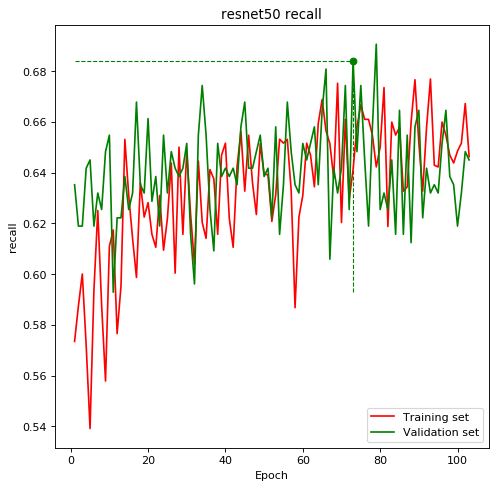

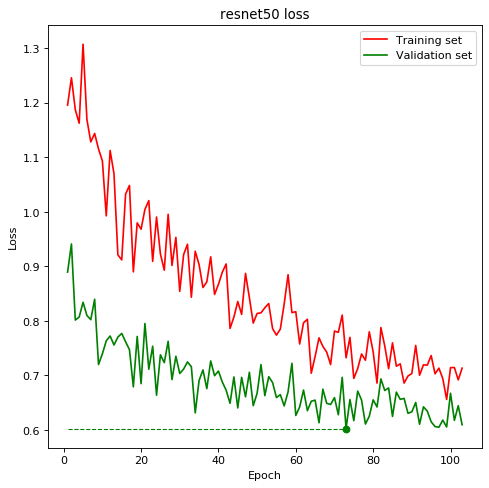

In [26]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 recall')
plt.ylabel('recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### RMSprop

In [27]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet50_calc_benign_or_malignant_best_RMSprop.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet50_calc_benign_or_malignant_best_RMSprop.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [28]:
# Train
history_resnet50_calc_benign_or_malignant_best_RMSprop = resnet50_calc_benign_or_malignant_best_RMSprop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 3.5723 - recall: 0.5781
Epoch 00001: val_loss improved from inf to 0.96161, saving model to ../model/resnet50_calc_benign_or_malignant_best_RMSprop.h5
5/5 [==============================] - 13s 3s/step - loss: 3.0736 - recall: 0.5765 - val_loss: 0.9616 - val_recall: 0.6417
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9658 - recall: 0.6152
Epoch 00002: val_loss improved from 0.96161 to 0.63809, saving model to ../model/resnet50_calc_benign_or_malignant_best_RMSprop.h5
5/5 [==============================] - 12s 2s/step - loss: 1.0965 - recall: 0.6094 - val_loss: 0.6381 - val_recall: 0.6156
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7328 - recall: 0.6130
Epoch 00003: val_loss improved from 0.63809 to 0.58254, saving model to ../model/resnet50_calc_benign_or_malignant_best_RMSprop.h5
5/

Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5451 - recall: 0.6957
Epoch 00059: val_loss did not improve from 0.55676
5/5 [==============================] - 10s 2s/step - loss: 0.5146 - recall: 0.7194 - val_loss: 0.6417 - val_recall: 0.6417
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4885 - recall: 0.7500
Epoch 00060: val_loss did not improve from 0.55676
5/5 [==============================] - 10s 2s/step - loss: 0.4779 - recall: 0.7516 - val_loss: 0.6440 - val_recall: 0.6580
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4483 - recall: 0.7441
Epoch 00061: val_loss did not improve from 0.55676
5/5 [==============================] - 11s 2s/step - loss: 0.4545 - recall: 0.7422 - val_loss: 0.6426 - val_recall: 0.6352
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4737 - recall: 0.7441
Epoch 00062: val_loss did not improve from 0.55676
5/5 [==============================] - 10s 2s/step - loss: 

In [29]:
models.save_model(resnet50_calc_benign_or_malignant_best_RMSprop, '../model/resnet50_calc_benign_or_malignant_end_RMSprop.h5')

In [30]:
tra_loss_fe = history_resnet50_calc_benign_or_malignant_best_RMSprop.history['loss']
tra_acc_fe = history_resnet50_calc_benign_or_malignant_best_RMSprop.history['recall']
val_loss_fe = history_resnet50_calc_benign_or_malignant_best_RMSprop.history['val_loss']
val_acc_fe = history_resnet50_calc_benign_or_malignant_best_RMSprop.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet50_calc_benign_or_malignant = models.load_model('../model/resnet50_calc_benign_or_malignant_best_RMSprop.h5')
test_loss_fe, test_acc_fe = resnet50_calc_benign_or_malignant_best_RMSprop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("resnet50 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 benign or malignant

Epoch [end]: 76
Epoch [opt]: 46
Valid recall [end]: 0.6221
Valid recall [opt]: 0.6808
Test recall [end]:  0.6350
Test recall [opt]:  0.6677
Valid loss [end]: 0.6904
Valid loss [opt]: 0.5568
Test loss [end]:  0.6947
Test loss [opt]:  0.5601


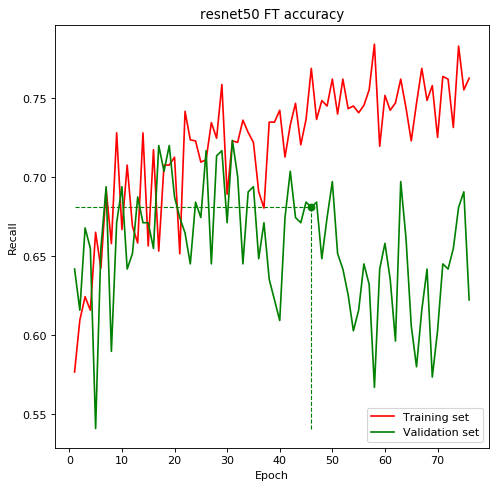

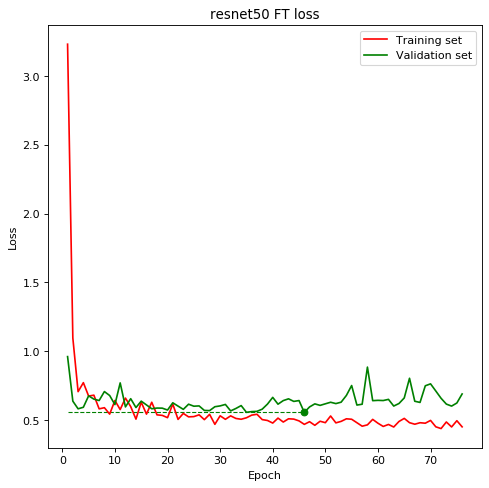

In [31]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adadelta

In [32]:
resnet50_calc_benign_or_malignant_best_Adadelta = create_resnet50(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet50_calc_benign_or_malignant_best_Adadelta.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet50_calc_benign_or_malignant_best_Adadelta.compile(optimizer=optimizers.Adadelta(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [33]:
# Train
history_resnet50_calc_benign_or_malignant_best_Adadelta = resnet50_calc_benign_or_malignant_best_Adadelta.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3022 - recall: 0.5020
Epoch 00001: val_loss improved from inf to 0.99670, saving model to ../model/resnet50_calc_benign_or_malignant_best_Adadelta.h5
5/5 [==============================] - 13s 3s/step - loss: 1.3502 - recall: 0.4953 - val_loss: 0.9967 - val_recall: 0.4658
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3479 - recall: 0.5156
Epoch 00002: val_loss did not improve from 0.99670
5/5 [==============================] - 10s 2s/step - loss: 1.3836 - recall: 0.5078 - val_loss: 1.0092 - val_recall: 0.4593
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2580 - recall: 0.5304
Epoch 00003: val_loss did not improve from 0.99670
5/5 [==============================] - 11s 2s/step - loss: 1.2846 - recall: 0.5272 - val_loss: 1.1272 - val_recall: 0.3616
Epoch 4/300
4/5 [=====================

Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2093 - recall: 0.5696
Epoch 00029: val_loss did not improve from 0.84193
5/5 [==============================] - 10s 2s/step - loss: 1.1800 - recall: 0.5731 - val_loss: 0.9689 - val_recall: 0.4984
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 1.1093 - recall: 0.5898
Epoch 00030: val_loss did not improve from 0.84193
5/5 [==============================] - 10s 2s/step - loss: 1.0927 - recall: 0.5859 - val_loss: 0.9659 - val_recall: 0.4788
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2399 - recall: 0.5312
Epoch 00031: val_loss did not improve from 0.84193
5/5 [==============================] - 10s 2s/step - loss: 1.2400 - recall: 0.5408 - val_loss: 0.9392 - val_recall: 0.4593
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2336 - recall: 0.5371
Epoch 00032: val_loss did not improve from 0.84193
5/5 [==============================] - 10s 2s/step - loss: 

In [34]:
models.save_model(resnet50_calc_benign_or_malignant_best_Adadelta, '../model/resnet50_calc_benign_or_malignant_end_Adadelta.h5')

In [35]:
tra_loss_fe = history_resnet50_calc_benign_or_malignant_best_Adadelta.history['loss']
tra_acc_fe = history_resnet50_calc_benign_or_malignant_best_Adadelta.history['recall']
val_loss_fe = history_resnet50_calc_benign_or_malignant_best_Adadelta.history['val_loss']
val_acc_fe = history_resnet50_calc_benign_or_malignant_best_Adadelta.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet50_calc_benign_or_malignant = models.load_model('../model/resnet50_calc_benign_or_malignant_best_Adadelta.h5')
test_loss_fe, test_acc_fe = resnet50_calc_benign_or_malignant_best_Adadelta.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("resnet50 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 benign or malignant

Epoch [end]: 50
Epoch [opt]: 20
Valid recall [end]: 0.5244
Valid recall [opt]: 0.5147
Test recall [end]:  0.5846
Test recall [opt]:  0.5549
Valid loss [end]: 0.8616
Valid loss [opt]: 0.8419
Test loss [end]:  0.7658
Test loss [opt]:  0.8128


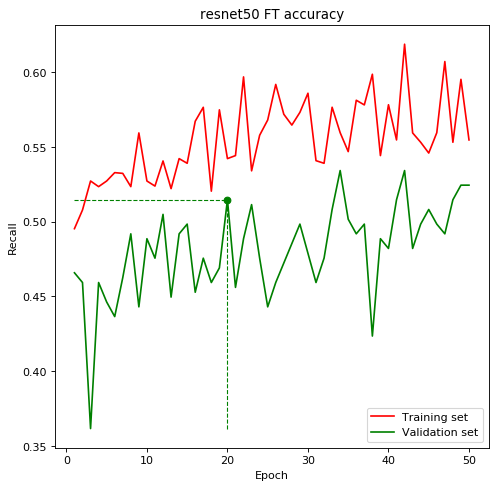

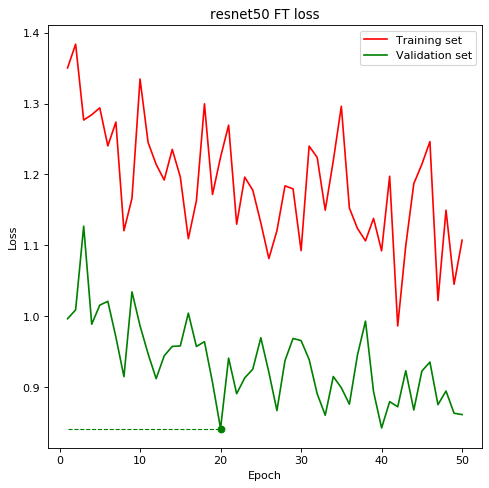

In [36]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adagrad

In [37]:
resnet50_calc_benign_or_malignant_best_Adagrad = create_resnet50(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet50_calc_benign_or_malignant_best_Adagrad.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet50_calc_benign_or_malignant_best_Adagrad.compile(optimizer=optimizers.Adagrad(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [38]:
# Train
history_resnet50_calc_benign_or_malignant_best_Adagrad = resnet50_calc_benign_or_malignant_best_Adagrad.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 1.6587 - recall: 0.5352
Epoch 00001: val_loss improved from inf to 0.96932, saving model to ../model/resnet50_calc_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 12s 2s/step - loss: 1.5953 - recall: 0.5391 - val_loss: 0.9693 - val_recall: 0.5049
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2178 - recall: 0.5761
Epoch 00002: val_loss improved from 0.96932 to 0.78174, saving model to ../model/resnet50_calc_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 10s 2s/step - loss: 1.2204 - recall: 0.5850 - val_loss: 0.7817 - val_recall: 0.5733
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.1170 - recall: 0.6445
Epoch 00003: val_loss improved from 0.78174 to 0.74609, saving model to ../model/resnet50_calc_benign_or_malignant_best_Adagrad.h5
5/

4/5 [=======================>......] - ETA: 1s - loss: 0.6677 - recall: 0.6289
Epoch 00058: val_loss did not improve from 0.59446
5/5 [==============================] - 11s 2s/step - loss: 0.6550 - recall: 0.6391 - val_loss: 0.6008 - val_recall: 0.6808
Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6836 - recall: 0.6445
Epoch 00059: val_loss did not improve from 0.59446
5/5 [==============================] - 11s 2s/step - loss: 0.6533 - recall: 0.6562 - val_loss: 0.6033 - val_recall: 0.6450
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6703 - recall: 0.6465
Epoch 00060: val_loss improved from 0.59446 to 0.58106, saving model to ../model/resnet50_calc_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 11s 2s/step - loss: 0.6612 - recall: 0.6463 - val_loss: 0.5811 - val_recall: 0.6580
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6194 - recall: 0.6739
Epoch 00061: val_loss did not improve from 

Epoch 88/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6177 - recall: 0.6836
Epoch 00088: val_loss did not improve from 0.57070
5/5 [==============================] - 11s 2s/step - loss: 0.6186 - recall: 0.6797 - val_loss: 0.5914 - val_recall: 0.6482
Epoch 89/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6360 - recall: 0.6699
Epoch 00089: val_loss did not improve from 0.57070
5/5 [==============================] - 10s 2s/step - loss: 0.6294 - recall: 0.6735 - val_loss: 0.5950 - val_recall: 0.6384
Epoch 90/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6179 - recall: 0.6543
Epoch 00090: val_loss did not improve from 0.57070
5/5 [==============================] - 10s 2s/step - loss: 0.6208 - recall: 0.6582 - val_loss: 0.6034 - val_recall: 0.6384
Epoch 91/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6151 - recall: 0.6652
Epoch 00091: val_loss did not improve from 0.57070
5/5 [==============================] - 10s 2s/step - loss: 

Epoch 119/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6076 - recall: 0.6855
Epoch 00119: val_loss did not improve from 0.56782
5/5 [==============================] - 10s 2s/step - loss: 0.6083 - recall: 0.6938 - val_loss: 0.5848 - val_recall: 0.6515
Epoch 120/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6028 - recall: 0.7031
Epoch 00120: val_loss did not improve from 0.56782
5/5 [==============================] - 11s 2s/step - loss: 0.6019 - recall: 0.6938 - val_loss: 0.6046 - val_recall: 0.6352
Epoch 121/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5977 - recall: 0.6953
Epoch 00121: val_loss did not improve from 0.56782
5/5 [==============================] - 10s 2s/step - loss: 0.6032 - recall: 0.6828 - val_loss: 0.5966 - val_recall: 0.6450
Epoch 122/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6068 - recall: 0.6652
Epoch 00122: val_loss did not improve from 0.56782
5/5 [==============================] - 10s 2s/step - lo

Epoch 149/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5779 - recall: 0.6895
Epoch 00149: val_loss did not improve from 0.55444
5/5 [==============================] - 10s 2s/step - loss: 0.5969 - recall: 0.6781 - val_loss: 0.5953 - val_recall: 0.6580
Epoch 150/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5698 - recall: 0.7051
Epoch 00150: val_loss did not improve from 0.55444
5/5 [==============================] - 11s 2s/step - loss: 0.5607 - recall: 0.7000 - val_loss: 0.5874 - val_recall: 0.6515
Epoch 151/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6188 - recall: 0.6602
Epoch 00151: val_loss did not improve from 0.55444
5/5 [==============================] - 10s 2s/step - loss: 0.6165 - recall: 0.6703 - val_loss: 0.5855 - val_recall: 0.6515
Epoch 152/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5651 - recall: 0.6978
Epoch 00152: val_loss did not improve from 0.55444
5/5 [==============================] - 10s 2s/step - lo

In [39]:
models.save_model(resnet50_calc_benign_or_malignant_best_Adagrad, '../model/resnet50_calc_benign_or_malignant_end_Adagrad.h5')

In [40]:
tra_loss_fe = history_resnet50_calc_benign_or_malignant_best_Adagrad.history['loss']
tra_acc_fe = history_resnet50_calc_benign_or_malignant_best_Adagrad.history['recall']
val_loss_fe = history_resnet50_calc_benign_or_malignant_best_Adagrad.history['val_loss']
val_acc_fe = history_resnet50_calc_benign_or_malignant_best_Adagrad.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet50_calc_benign_or_malignant = models.load_model('../model/resnet50_calc_benign_or_malignant_best_Adagrad.h5')
test_loss_fe, test_acc_fe = resnet50_calc_benign_or_malignant_best_Adagrad.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("resnet50 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 benign or malignant

Epoch [end]: 163
Epoch [opt]: 133
Valid recall [end]: 0.6775
Valid recall [opt]: 0.6808
Test recall [end]:  0.6647
Test recall [opt]:  0.6706
Valid loss [end]: 0.5779
Valid loss [opt]: 0.5544
Test loss [end]:  0.5622
Test loss [opt]:  0.5677


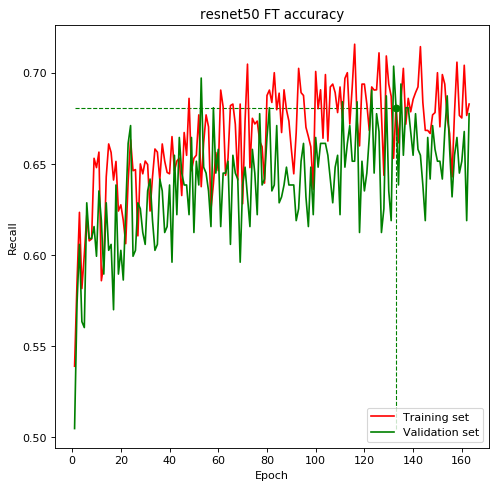

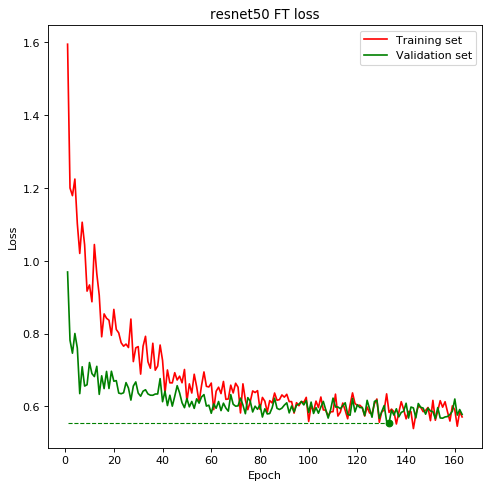

In [41]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adamax

In [42]:
resnet50_calc_benign_or_malignant_best_Adamax = create_resnet50(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet50_calc_benign_or_malignant_best_Adamax.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet50_calc_benign_or_malignant_best_Adamax.compile(optimizer=optimizers.Adamax(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [43]:
# Train
history_resnet50_calc_benign_or_malignant_best_Adamax = resnet50_calc_benign_or_malignant_best_Adamax.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 2.3638 - recall: 0.6087
Epoch 00001: val_loss improved from inf to 1.00272, saving model to ../model/resnet50_calc_benign_or_malignant_best_Adamax.h5
5/5 [==============================] - 12s 2s/step - loss: 2.4143 - recall: 0.5697 - val_loss: 1.0027 - val_recall: 0.5342
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0809 - recall: 0.6174
Epoch 00002: val_loss improved from 1.00272 to 0.62448, saving model to ../model/resnet50_calc_benign_or_malignant_best_Adamax.h5
5/5 [==============================] - 11s 2s/step - loss: 1.0490 - recall: 0.6173 - val_loss: 0.6245 - val_recall: 0.6547
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7322 - recall: 0.6652
Epoch 00003: val_loss improved from 0.62448 to 0.59094, saving model to ../model/resnet50_calc_benign_or_malignant_best_Adamax.h5
5/5 [

5/5 [==============================] - 10s 2s/step - loss: 0.5293 - recall: 0.7092 - val_loss: 0.5637 - val_recall: 0.6580
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5338 - recall: 0.7043
Epoch 00030: val_loss did not improve from 0.56368
5/5 [==============================] - 10s 2s/step - loss: 0.5426 - recall: 0.7007 - val_loss: 0.5853 - val_recall: 0.6580
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4998 - recall: 0.7348
Epoch 00031: val_loss improved from 0.56368 to 0.55580, saving model to ../model/resnet50_calc_benign_or_malignant_best_Adamax.h5
5/5 [==============================] - 10s 2s/step - loss: 0.5173 - recall: 0.7194 - val_loss: 0.5558 - val_recall: 0.6678
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5368 - recall: 0.7207
Epoch 00032: val_loss did not improve from 0.55580
5/5 [==============================] - 10s 2s/step - loss: 0.5525 - recall: 0.7125 - val_loss: 0.5792 - val_recall: 0.6319


4/5 [=======================>......] - ETA: 1s - loss: 0.5409 - recall: 0.6913
Epoch 00060: val_loss did not improve from 0.55580
5/5 [==============================] - 10s 2s/step - loss: 0.5377 - recall: 0.6990 - val_loss: 0.5735 - val_recall: 0.6808
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5086 - recall: 0.7129
Epoch 00061: val_loss did not improve from 0.55580
5/5 [==============================] - 10s 2s/step - loss: 0.5111 - recall: 0.7203 - val_loss: 0.5681 - val_recall: 0.6515
Epoch 00061: early stopping


In [44]:
models.save_model(resnet50_calc_benign_or_malignant_best_Adamax, '../model/resnet50_calc_benign_or_malignant_end_Adamax.h5')

In [45]:
tra_loss_fe = history_resnet50_calc_benign_or_malignant_best_Adamax.history['loss']
tra_acc_fe = history_resnet50_calc_benign_or_malignant_best_Adamax.history['recall']
val_loss_fe = history_resnet50_calc_benign_or_malignant_best_Adamax.history['val_loss']
val_acc_fe = history_resnet50_calc_benign_or_malignant_best_Adamax.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet50_calc_benign_or_malignant = models.load_model('../model/resnet50_calc_benign_or_malignant_best_Adamax.h5')
test_loss_fe, test_acc_fe = resnet50_calc_benign_or_malignant_best_Adamax.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("resnet50 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 benign or malignant

Epoch [end]: 61
Epoch [opt]: 31
Valid recall [end]: 0.6515
Valid recall [opt]: 0.6678
Test recall [end]:  0.7003
Test recall [opt]:  0.6944
Valid loss [end]: 0.5681
Valid loss [opt]: 0.5558
Test loss [end]:  0.5388
Test loss [opt]:  0.5462


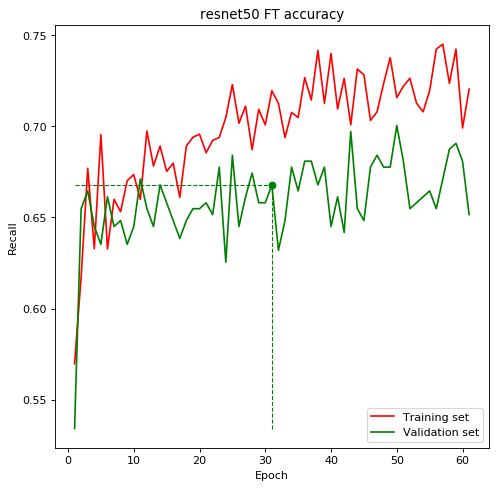

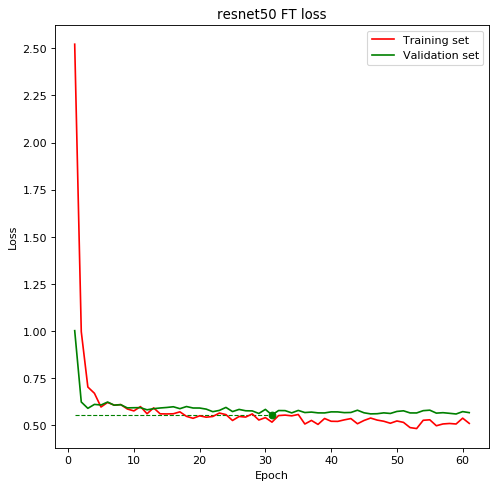

In [46]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

## Nadam

In [47]:
resnet50_calc_benign_or_malignant_best_Nadam = create_resnet50(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet50_calc_benign_or_malignant_best_Nadam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet50_calc_benign_or_malignant_best_Nadam.compile(optimizer=optimizers.Nadam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [48]:
# Train
history_resnet50_calc_benign_or_malignant_best_Nadam = resnet50_calc_benign_or_malignant_best_Nadam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 4.7175 - recall: 0.5674
Epoch 00001: val_loss improved from inf to 0.65687, saving model to ../model/resnet50_calc_benign_or_malignant_best_Nadam.h5
5/5 [==============================] - 12s 2s/step - loss: 3.9705 - recall: 0.5680 - val_loss: 0.6569 - val_recall: 0.6547
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6990 - recall: 0.6022
Epoch 00002: val_loss improved from 0.65687 to 0.62202, saving model to ../model/resnet50_calc_benign_or_malignant_best_Nadam.h5
5/5 [==============================] - 11s 2s/step - loss: 0.6975 - recall: 0.5952 - val_loss: 0.6220 - val_recall: 0.6612
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6233 - recall: 0.6348
Epoch 00003: val_loss improved from 0.62202 to 0.60038, saving model to ../model/resnet50_calc_benign_or_malignant_best_Nadam.h5
5/5 [===

Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4839 - recall: 0.7478
Epoch 00059: val_loss did not improve from 0.55785
5/5 [==============================] - 11s 2s/step - loss: 0.4887 - recall: 0.7534 - val_loss: 0.5689 - val_recall: 0.6873
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4882 - recall: 0.7500
Epoch 00060: val_loss did not improve from 0.55785
5/5 [==============================] - 10s 2s/step - loss: 0.4921 - recall: 0.7453 - val_loss: 0.5821 - val_recall: 0.6580
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5094 - recall: 0.7324
Epoch 00061: val_loss did not improve from 0.55785
5/5 [==============================] - 11s 2s/step - loss: 0.4986 - recall: 0.7359 - val_loss: 0.5735 - val_recall: 0.6775
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4726 - recall: 0.7609
Epoch 00062: val_loss did not improve from 0.55785
5/5 [==============================] - 10s 2s/step - loss: 

In [49]:
models.save_model(resnet50_calc_benign_or_malignant_best_Nadam, '../model/resnet50_calc_benign_or_malignant_end_Nadam.h5')

In [50]:
tra_loss_fe = history_resnet50_calc_benign_or_malignant_best_Nadam.history['loss']
tra_acc_fe = history_resnet50_calc_benign_or_malignant_best_Nadam.history['recall']
val_loss_fe = history_resnet50_calc_benign_or_malignant_best_Nadam.history['val_loss']
val_acc_fe = history_resnet50_calc_benign_or_malignant_best_Nadam.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet50_calc_benign_or_malignant = models.load_model('../model/resnet50_calc_benign_or_malignant_best_Nadam.h5')
test_loss_fe, test_acc_fe = resnet50_calc_benign_or_malignant_best_Nadam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("resnet50 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 benign or malignant

Epoch [end]: 63
Epoch [opt]: 33
Valid recall [end]: 0.6612
Valid recall [opt]: 0.6906
Test recall [end]:  0.6795
Test recall [opt]:  0.7240
Valid loss [end]: 0.5840
Valid loss [opt]: 0.5578
Test loss [end]:  0.5575
Test loss [opt]:  0.5412


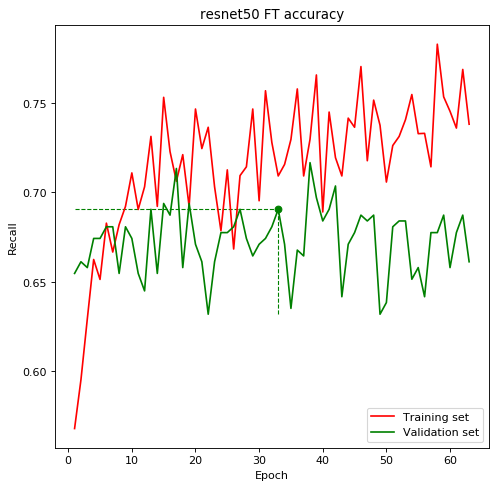

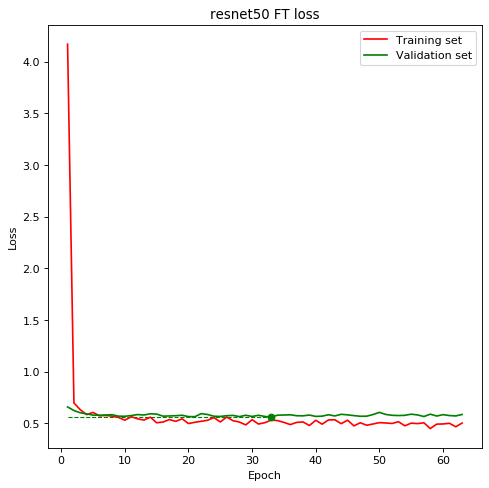

In [51]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#### fine tuning

In [15]:
resnet50_calc_benign_or_malignant_fine_RMSprop = models.load_model('../model/resnet50_calc_benign_or_malignant_best_RMSprop.h5')

for layer in resnet50_calc_benign_or_malignant_fine_RMSprop.layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
resnet50_calc_benign_or_malignant_fine_RMSprop.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

resnet50_calc_benign_or_malignant_fine_RMSprop.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [16]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/resnet50_calc_benign_or_malignant_fine_RMSprop_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [17]:
history_fit = resnet50_calc_benign_or_malignant_fine_RMSprop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5093 - recall: 0.7129
Epoch 00001: val_loss improved from inf to 0.58790, saving model to ../model/resnet50_calc_benign_or_malignant_fine_RMSprop_best.h5
5/5 [==============================] - 13s 3s/step - loss: 0.5063 - recall: 0.7188 - val_loss: 0.5879 - val_recall: 0.6678
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5282 - recall: 0.7109
Epoch 00002: val_loss did not improve from 0.58790
5/5 [==============================] - 11s 2s/step - loss: 0.5151 - recall: 0.7141 - val_loss: 0.5953 - val_recall: 0.6580
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5007 - recall: 0.7348
Epoch 00003: val_loss improved from 0.58790 to 0.56513, saving model to ../model/resnet50_calc_benign_or_malignant_fine_RMSprop_best

Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5065 - recall: 0.7188
Epoch 00029: val_loss did not improve from 0.56128
5/5 [==============================] - 10s 2s/step - loss: 0.5197 - recall: 0.7234 - val_loss: 0.5843 - val_recall: 0.6287
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4815 - recall: 0.7578
Epoch 00030: val_loss did not improve from 0.56128
5/5 [==============================] - 11s 2s/step - loss: 0.4792 - recall: 0.7609 - val_loss: 0.5821 - val_recall: 0.6645
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5308 - recall: 0.6797
Epoch 00031: val_loss did not improve from 0.56128
5/5 [==============================] - 11s 2s/step - loss: 0.5255 - recall: 0.6938 - val_loss: 0.5698 - val_recall: 0.6710
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4599 - recall: 0.7565
Epoch 00032: val_loss did not improve from 0.56128
5/5 [==============================] - 11s 2s/step - loss: 

Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4927 - recall: 0.7261
Epoch 00059: val_loss did not improve from 0.54612
5/5 [==============================] - 10s 2s/step - loss: 0.4913 - recall: 0.7364 - val_loss: 0.5845 - val_recall: 0.6319
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5264 - recall: 0.7109
Epoch 00060: val_loss did not improve from 0.54612
5/5 [==============================] - 10s 2s/step - loss: 0.5288 - recall: 0.7109 - val_loss: 0.5668 - val_recall: 0.7101
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5046 - recall: 0.7043
Epoch 00061: val_loss did not improve from 0.54612
5/5 [==============================] - 11s 2s/step - loss: 0.4986 - recall: 0.7177 - val_loss: 0.5813 - val_recall: 0.6547
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5018 - recall: 0.7246
Epoch 00062: val_loss did not improve from 0.54612
5/5 [==============================] - 10s 2s/step - loss: 

In [18]:
models.save_model(resnet50_calc_benign_or_malignant_fine_RMSprop, '../model/resnet50_calc_benign_or_malignant_fine_RMSprop_end.h5')

In [19]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet50_calc_benign_or_malignant_fine_RMSprop = models.load_model('../model/resnet50_calc_benign_or_malignant_fine_RMSprop_best.h5')
test_loss_fe, test_acc_fe = resnet50_calc_benign_or_malignant_fine_RMSprop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_benign_or_malignant_fine_RMSprop.evaluate(test_images, test_labels, verbose=False)

print("resnet50 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 Fine Tuning

Epoch [end]: 85
Epoch [opt]: 55
Valid recall [end]: 0.6612
Valid recall [opt]: 0.6906
Test recall [end]:  0.6677
Test recall [opt]:  0.6677
Valid loss [end]: 0.5723
Valid loss [opt]: 0.5461
Test loss [end]:  0.5601
Test loss [opt]:  0.5601


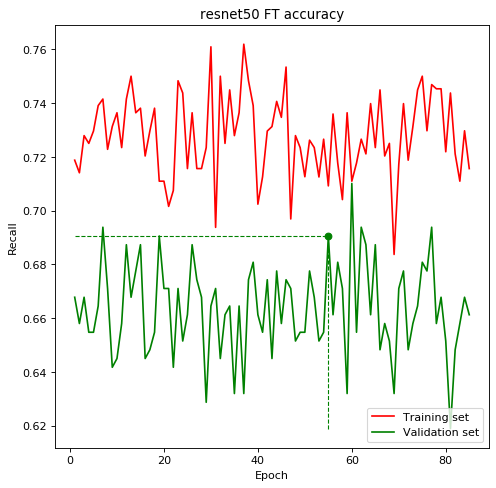

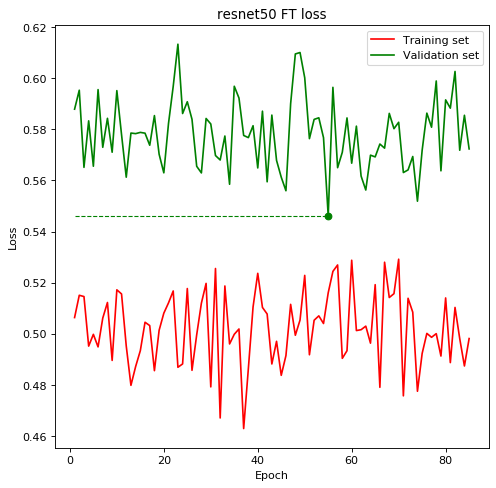

In [20]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [21]:
resnet50_calc_benign_or_malignant_fine_RMSprop2 = models.load_model('../model/resnet50_calc_benign_or_malignant_fine_RMSprop_best.h5')

for layer in resnet50_calc_benign_or_malignant_fine_RMSprop2.layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
resnet50_calc_benign_or_malignant_fine_RMSprop2.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

resnet50_calc_benign_or_malignant_fine_RMSprop2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [22]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/resnet50_calc_benign_or_malignant_fine_RMSprop_best2.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [23]:
history_fit = resnet50_calc_benign_or_malignant_fine_RMSprop2.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5247 - recall: 0.7168
Epoch 00001: val_loss improved from inf to 0.60816, saving model to ../model/resnet50_calc_benign_or_malignant_fine_RMSprop_best2.h5
5/5 [==============================] - 12s 2s/step - loss: 0.5186 - recall: 0.7188 - val_loss: 0.6082 - val_recall: 0.6384
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5007 - recall: 0.7227
Epoch 00002: val_loss improved from 0.60816 to 0.56429, saving model to ../model/resnet50_calc_benign_or_malignant_fine_RMSprop_best2.h5
5/5 [==============================] - 11s 2s/step - loss: 0.5014 - recall: 0.7266 - val_loss: 0.5643 - val_recall: 0.6938
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4836 - recall: 0.7261
Epoch 00003: val_loss did not improve from 0.56429
5/5 [==============================] - 10s 2s/step - loss: 0.4968 - re

In [24]:
models.save_model(resnet50_calc_benign_or_malignant_fine_RMSprop2, '../model/resnet50_calc_benign_or_malignant_fine_RMSprop_end2.h5')

In [25]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet50_calc_benign_or_malignant_fine_RMSprop2 = models.load_model('../model/resnet50_calc_benign_or_malignant_fine_RMSprop_best2.h5')
test_loss_fe, test_acc_fe = resnet50_calc_benign_or_malignant_fine_RMSprop2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_benign_or_malignant_fine_RMSprop2.evaluate(test_images, test_labels, verbose=False)

print("resnet50 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 Fine Tuning

Epoch [end]: 53
Epoch [opt]: 23
Valid recall [end]: 0.7003
Valid recall [opt]: 0.6612
Test recall [end]:  0.6677
Test recall [opt]:  0.6677
Valid loss [end]: 0.5739
Valid loss [opt]: 0.5529
Test loss [end]:  0.5601
Test loss [opt]:  0.5601


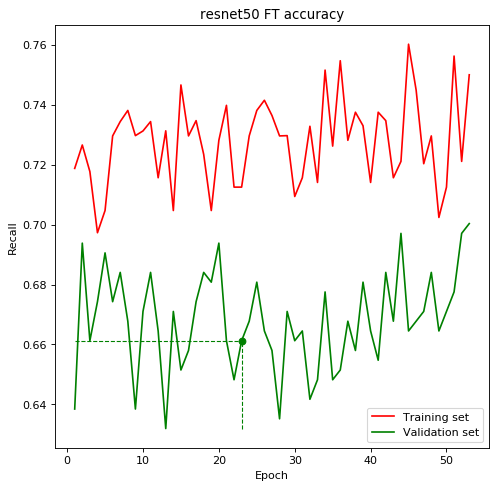

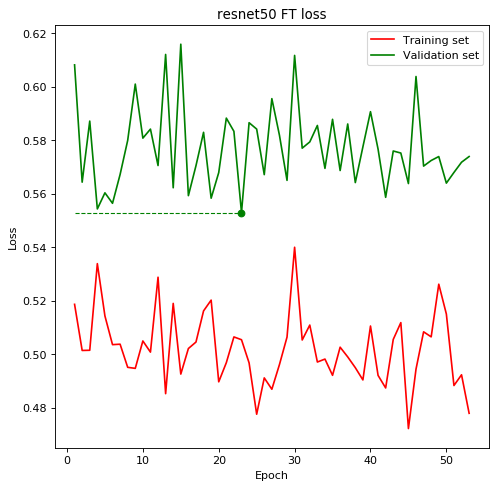

In [26]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [15]:
resnet50_calc_benign_or_malignant_fine_RMSprop3 = models.load_model('../model/resnet50_calc_benign_or_malignant_fine_RMSprop_best2.h5')

for layer in resnet50_calc_benign_or_malignant_fine_RMSprop3.layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
resnet50_calc_benign_or_malignant_fine_RMSprop3.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

resnet50_calc_benign_or_malignant_fine_RMSprop3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [16]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/resnet50_calc_benign_or_malignant_fine_RMSprop_best3.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [17]:
history_fit = resnet50_calc_benign_or_malignant_fine_RMSprop3.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4670 - recall: 0.7578
Epoch 00001: val_loss improved from inf to 0.61929, saving model to ../model/resnet50_calc_benign_or_malignant_fine_RMSprop_best3.h5
5/5 [==============================] - 13s 3s/step - loss: 0.4850 - recall: 0.7500 - val_loss: 0.6193 - val_recall: 0.6319
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4969 - recall: 0.7402
Epoch 00002: val_loss improved from 0.61929 to 0.58508, saving model to ../model/resnet50_calc_benign_or_malignant_fine_RMSprop_best3.h5
5/5 [==============================] - 12s 2s/step - loss: 0.4877 - recall: 0.7422 - val_loss: 0.5851 - val_recall: 0.6580
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5027 - recall: 0.7363
Epoch 00003: val_loss improved from 0.58508 t

Epoch 28/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5164 - recall: 0.6957
Epoch 00028: val_loss did not improve from 0.55679
5/5 [==============================] - 11s 2s/step - loss: 0.5056 - recall: 0.7041 - val_loss: 0.6081 - val_recall: 0.6319
Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4891 - recall: 0.7227
Epoch 00029: val_loss did not improve from 0.55679
5/5 [==============================] - 10s 2s/step - loss: 0.4981 - recall: 0.7156 - val_loss: 0.5803 - val_recall: 0.6743
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5248 - recall: 0.7266
Epoch 00030: val_loss did not improve from 0.55679
5/5 [==============================] - 10s 2s/step - loss: 0.5316 - recall: 0.7160 - val_loss: 0.6085 - val_recall: 0.6678
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5067 - recall: 0.7402
Epoch 00031: val_loss did not improve from 0.55679
5/5 [==============================] - 10s 2s/step - loss: 

In [18]:
models.save_model(resnet50_calc_benign_or_malignant_fine_RMSprop3, '../model/resnet50_calc_benign_or_malignant_fine_RMSprop_end3.h5')

In [19]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet50_calc_benign_or_malignant_fine_RMSprop3 = models.load_model('../model/resnet50_calc_benign_or_malignant_fine_RMSprop_best3.h5')
test_loss_fe, test_acc_fe = resnet50_calc_benign_or_malignant_fine_RMSprop3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_benign_or_malignant_fine_RMSprop3.evaluate(test_images, test_labels, verbose=False)

print("resnet50 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 Fine Tuning

Epoch [end]: 51
Epoch [opt]: 21
Valid recall [end]: 0.6840
Valid recall [opt]: 0.6743
Test recall [end]:  0.6677
Test recall [opt]:  0.6677
Valid loss [end]: 0.5728
Valid loss [opt]: 0.5568
Test loss [end]:  0.5601
Test loss [opt]:  0.5601


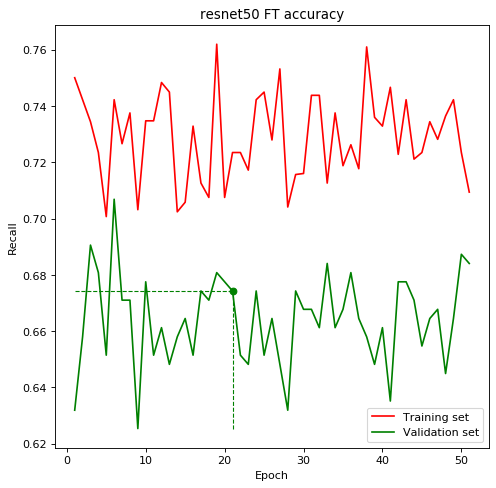

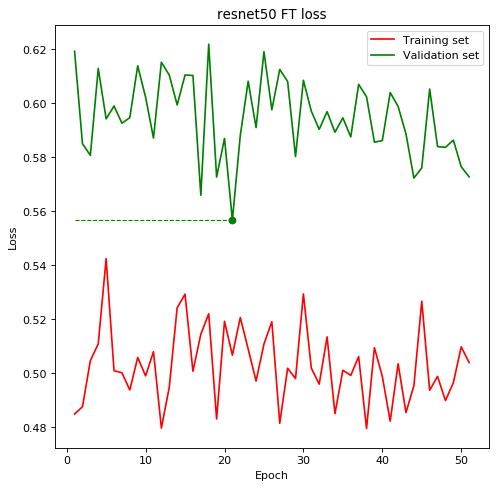

In [20]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();